# Model Training and Evaluation

Sub-Task 1:Build churn model(s) to try to predict the churn probability of any customer.

Sub-Task 2:Evaluate your model, using a holdout set, and with metrics of your choosing.

Sub-Task 3:Interpret the results and use them to formulate answers to the client’s hypotheses and questions.

### Import packages

In [30]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import shap
import logging

from sklearn.model_selection import train_test_split

# Handle class imbalance
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import (TomekLinks, 
                                     NeighbourhoodCleaningRule as NCR, 
                                     RandomUnderSampler)


# ML

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# # Neural Network
# from scikeras.wrappers import KerasClassifier
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers.core import Dropout
# from keras import regularizers
# from keras.layers.normalization import BatchNormalization
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Assemble pipeline(s)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn import set_config

# Performance metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, classification_report
from mlxtend.evaluate import lift_score

In [2]:
os.environ["OMP_NUM_THREADS"] = "1"  #export OMP_NUM_THREADS=1

In [3]:
# Show plots in jupyter notebook
%matplotlib inline

In [4]:
# Set plot style
sns.set(color_codes=True)

In [5]:
# Set maximum number of columns to be displayed
pd.set_option('display.max_columns', 100)

In [6]:
# load JS visualization code to notebook
shap.initjs()

#### Loading data (pickle)

In [7]:
os.getcwd()

'/Users/soumyadeepray/My Documents/DS_Projects/BCG_Customer_Churn_Case_Study/notebooks'

In [10]:
os.chdir('/Users/soumyadeepray/My Documents/DS_Projects/BCG_Customer_Churn_Case_Study/artifacts')

In [11]:
df = pd.read_pickle('./processed_data.pkl')
df.head(5)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,origin_up,pow_max,mean_year_price_off_peak_var_x,mean_year_price_peak_var_x,mean_year_price_mid_peak_var_x,mean_year_price_off_peak_fix_x,mean_year_price_peak_fix_x,mean_year_price_mid_peak_fix_x,mean_year_price_off_peak_x,mean_year_price_peak_x,mean_year_price_mid_peak,mean_year_price_off_peak_var_y,mean_year_price_peak_var_y,mean_year_price_mid_peak_var_y,mean_year_price_off_peak_fix_y,mean_year_price_peak_fix_y,mean_year_price_mid_peak_fix_y,mean_year_price_off_peak_y,mean_year_price_peak_y,mean_year_price_med_peak_x,mean_year_price_off_peak_var,mean_year_price_peak_var,mean_year_price_mid_peak_var,mean_year_price_off_peak_fix,mean_year_price_peak_fix,mean_year_price_mid_peak_fix,mean_year_price_off_peak,mean_year_price_peak,mean_year_price_med_peak_y,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0.0,54946.0,0.0,0.00,0.0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693,3,30.0,5.0,2.0,6.0
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660.0,0.0,0.0,189.95,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471,7,76.0,7.0,76.0,4.0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544.0,0.0,0.0,47.96,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,6,68.0,3.0,68.0,8.0
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584.0,0.0,0.0,240.04,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.149330,0.000000,0.000000,44.444710,0.000000,0.000000,44.594040,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471,6,69.0,2.0,69.0,9.0
4,4,149d57cf92fc41cf94415803a877cb

### Defining sampling approaches

Churn data sets suffer usually from high-class imbalance. This means that the number of churners are in the minority. To deal with this class imbalance the package imbalanced-learn comes with a battery of different sampling approaches.

- `SMOTE - (Synthetic Minority Oversampling Technique)` is an oversampling technique where the synthetic samples are generated for the minority class. 

- `ADASYN - (Adaptive Synthetic)` is an algorithm that generates synthetic data. Its greatest advantages are not copying the same minority data, and generating more data for “harder to learn" examples.

- `TomekLinks` is used as an undersampling method and removes noisy and borderline majority class examples. The procedure for finding Tomek Links can be used to locate all cross-class nearest neighbors. If the examples in the minority class are held constant, the procedure can be used to find all of those examples in the majority class that are closest to the minority class, then removed.

- `NCR - Neighborhood Cleaning rule` is an undersampling technique that combines both the Condensed Nearest Neighbor (CNN) Rule to remove redundant examples and the Edited Nearest Neighbors (ENN) Rule to remove noisy or ambiguous examples.


In [12]:
# Store different sampling approaches
sampl_app = dict()

# No sampling
#sampl_app['no_sampling'] = ('no_sampling', None)

# SMOTE
sampl_app['o_SMOTE'] = ('smote', SMOTE())

# ADASYN (Adaptive Synthetic) 
sampl_app['o_ADASYN'] = ('adasyn', ADASYN(sampling_strategy='not minority'))

# TomekLinks
sampl_app['u_TomekLinks'] = ('tomeklinks', TomekLinks())

# # NCR
# sampl_app['u_NCR'] = ('ncr', NCR())

# # SMOTE + TomekLinks
# sampl_app['h_SMOTE_Tomek'] = imbPipeline([('smote', SMOTE()),
#                                           ('tomeklinks', TomekLinks())])

# # SMOTE + NCR
# sampl_app['h_SMOTE_NCR'] = imbPipeline([('smote', SMOTE()),
#                                         ('ncr', 
#                                          NCR(sampling_strategy='not majority'))]
#                                        )

To use these sampling methods later in the pipeline, they have to be brought in the right format (tuple) first. Approaches that use a combination of multiple sampling methods, have to be wrapped in an `imbPipeline` object.

In [ ]:
# Define different ML models

# Feed Forward Neural Network
# https://github.com/naomifridman/Neural-Network-Churn-Prediction/blob/master/FFNN_churn_predict_0_12174.ipynb
def ffnn_mdl(meta):
    
    lsize=128
    n_features_in_ = meta["n_features_in_"]

    model = Sequential()
    model.add(Dense(lsize, input_dim=n_features_in_,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.25))
    model.add(Dense(int(lsize/2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.25))
    model.add(Dense(int(lsize/4),kernel_regularizer=regularizers.l2(0.1), 
                    activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(1, activation='sigmoid'))
    #metrics=[auroc] causes issues # adadelta was original
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    return model

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2,patience=1, 
                              min_lr=0.0001)
reduce_val_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, 
                                  patience=1, min_lr=0.0001)
es = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto')

callbacks_list = [es, reduce_lr, reduce_val_lr]


ffnn = KerasClassifier(ffnn_mdl,
                       epochs=50,
                       batch_size=64,
                       validation_split=0.2,
                       callbacks=callbacks_list,
                       verbose=0)

In [13]:
# Linear model (logistic regression)
lr = LogisticRegression(solver='saga',
                            warm_start=True,
                            max_iter=1000)

# RandomForest
rf = RandomForestClassifier()

# XGB
xgb = XGBClassifier(tree_method="hist",
                        verbosity=0,
                        silent=True)

# LR, XGB,RF, FFNN
lr_xgb_rf = VotingClassifier(estimators=[('lr', lr),
                                         ('xgb', xgb),
                                         ('rf', rf)
                                        ], voting='soft')

# knn
knn = KNeighborsClassifier()

# svc
svc = SVC()


#### Splitting data


First of all we will split the data into the variable that we are trying to predict y (churn) and those variables that we will use to predict churn X (the
rest)

In [14]:
y = df["churn"]
X = df.drop(labels = ["Unnamed: 0","origin_up", "id","churn"],axis = 1)

In [15]:
# Store them as tuples in a list
models = [#('lr', lr),
          ('rf', rf),
          ('xgb', xgb)
         #  ('svc',svc),
         #  ('gnb', gnb),
        #   ('lgb', lgb),
         #  ('knn', knn)
        #   ('gev_nn', gev_nn),
        #   ('ffnn', ffnn),
        #  ('lr_xgb_rf', lr_xgb_rf)
        #   ('lr_xgb_rf_ffnn', lr_xgb_rf_ffnn)]
         ]

#### Initial pipeline

In [16]:
ppl = imbPipeline([
    ('transformation', ColumnTransformer([
        ('num',make_pipeline(
            SimpleImputer(strategy='mean'),
            MinMaxScaler()),
         make_column_selector(dtype_include='number')
        ),
        ('cat',make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse=False, handle_unknown='ignore')),
         make_column_selector(dtype_include='object')
        )])
    )
])

initial_steps = len(ppl.steps)

#### Scores to track


In [17]:
scorer = {
    'lift_score': make_scorer(lift_score),
    'roc_auc':'roc_auc', 
    'f1_macro':'f1_macro',
    'precision':'precision', 
    'recall':'recall'
}

#### The benchmark loops

In [73]:
model_results = {} #Store model performance

for m in models:

    sampling_results = {} # Store sampling performance for respective model
    for sa in sampl_app.keys():
        logging.info(f"== Running {m[0]} with {sa} strategy ==")
          
        # Extend initial pipeline by sampling approach and model
        # Since some sampling approaches have multiple steps 
        # (e.g., SMOTE + RND) I have to append them via loop
        if hasattr(sampl_app[sa], 'steps'):
            for s in sampl_app[sa].steps:
                ppl.steps.append(s)
        else:
            ppl.steps.append(sampl_app[sa])
            
        # Add model to pipeline
        ppl.steps.append(m)

        # Configure KFold and CV
        rsf = RepeatedStratifiedKFold(n_repeats=5, random_state=42)
            
        scores = cross_validate(ppl, X, y, 
                                    cv=rsf, 
                                    scoring=scorer, 
                                    verbose=0, 
                                    n_jobs=1,
                                    error_score='raise',
                                    fit_params=None,
                                    return_estimator=False
                                   )
        
        mean_scores = {}
        for key in scores:
            sum = scores[key].mean()
            mean_scores[key] = sum    

        # Write results in dict
        sampling_results[sa] = mean_scores
            
        # After running CV we reset pipeline to initial state
        # to be clean for next iteration
        ppl = ppl[:initial_steps]
        
    # Write results in dict
    model_results[m[0]] = sampling_results

    # After one data set has been benchmarked we persistent the results
    file_to_write = open(f"./data_set_results_{m[0]}.pickle", "wb")
    pickle.dump(model_results, file_to_write)
    logging.info(f"Results for {m} have been written to pickle file")

# Done
logging.info("Benchmarking done")


#### Model Validation

In [76]:
model_results['rf']

{'o_SMOTE': {'fit_time': 4.761667051315308,
  'score_time': 0.09340847969055176,
  'test_lift_score': 4.811541774614973,
  'test_roc_auc': 0.6681965815542777,
  'test_f1_macro': 0.585770866415839,
  'test_precision': 0.4674753442101366,
  'test_recall': 0.1481336783954611},
 'o_ADASYN': {'fit_time': 2.415917730331421,
  'score_time': 0.08530901908874512,
  'test_lift_score': 7.94747534950765,
  'test_roc_auc': 0.6784370370644058,
  'test_f1_macro': 0.5395181932701515,
  'test_precision': 0.7721952737162933,
  'test_recall': 0.06990046284775792},
 'u_TomekLinks': {'fit_time': 2.9360476684570314,
  'score_time': 0.08451800346374512,
  'test_lift_score': 7.552340909034334,
  'test_roc_auc': 0.6807209412038087,
  'test_f1_macro': 0.5431218166634302,
  'test_precision': 0.7338026542455937,
  'test_recall': 0.0746981535858259}}

From the scores, we find that SMOTE is the most significant sampling technique. And XGBoost outperformed Random Forest in terms of f1 score and recall.

In [75]:
model_results_df = pd.DataFrame.from_dict(model_results)
model_results_df

,rf,xgb
o_SMOTE,"{'fit_time': 4.761667051315308, 'score_time': ...","{'fit_time': 0.7976608467102051, 'score_time':..."
o_ADASYN,"{'fit_time': 2.415917730331421, 'score_time': ...","{'fit_time': 0.5104711627960206, 'score_time':..."
u_TomekLinks,"{'fit_time': 2.9360476684570314, 'score_time':...","{'fit_time': 1.1192352676391601, 'score_time':..."


Creating the best XGBoost model

In [53]:
X = pd.get_dummies(X, columns=['channel_sales'], prefix='channel')

#Dropping categories having very less values
X = X.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
X.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,mean_year_price_off_peak_var_x,mean_year_price_peak_var_x,mean_year_price_mid_peak_var_x,mean_year_price_off_peak_fix_x,mean_year_price_peak_fix_x,mean_year_price_mid_peak_fix_x,mean_year_price_off_peak_x,mean_year_price_peak_x,mean_year_price_mid_peak,mean_year_price_off_peak_var_y,mean_year_price_peak_var_y,mean_year_price_mid_peak_var_y,mean_year_price_off_peak_fix_y,mean_year_price_peak_fix_y,mean_year_price_mid_peak_fix_y,mean_year_price_off_peak_y,mean_year_price_peak_y,mean_year_price_med_peak_x,mean_year_price_off_peak_var,mean_year_price_peak_var,mean_year_price_mid_peak_var,mean_year_price_off_peak_fix,mean_year_price_peak_fix,mean_year_price_mid_peak_fix,mean_year_price_off_peak,mean_year_price_peak,mean_year_price_med_peak_y,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,0.0,54946.0,0.0,0.00,0.0,1.78,0.114481,0.098142,40.606701,1,0.00,25.44,25.44,2,678.99,43.648,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693,3,30.0,5.0,2.0,6.0,0,0,1,0,0
1,4660.0,0.0,0.0,189.95,0.0,16.27,0.145711,0.000000,44.311378,0,0.00,16.38,16.38,1,18.89,13.800,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471,7,76.0,7.0,76.0,4.0,1,0,0,0,0
2,544.0,0.0,0.0,47.96,0.0,38.72,0.165794,0.087899,44.311378,0,0.00,28.60,28.60,1,6.60,13.856,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,6,68.0,3.0,68.0,8.0,0,0,1,0,0
3,1584.0,0.0,0.0,240.04,0.0,19.83,0.146694,0.000000,44.311378,0,0.00,30.22,30.22,1,25.46,13.200,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.149330,0.000000,0.000000,44.444710,0.000000,0.000000,44.594040,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471,6,69.0,2.0,69.0,9.0,0,0,0,1,0
4,4425.0,0.0,526.0,445.75,0.0,131.73,0.116900,0.100015,40.606701,0,52.32,44.91,44.91,1,47.98,19.800,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,40.812330,24.516531,16.348129,0.121266,0.102368,0.073728,40.728885,24.437330,16.291555,4

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25,random_state=42)

In [56]:
# Instantiate the grid search model
pipe = imbPipeline([
    ('transformation', ColumnTransformer([
        ('num',make_pipeline(
            SimpleImputer(strategy='mean'),
            MinMaxScaler()),
         make_column_selector(dtype_include='number')
        ),
        ('cat',make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse=False, handle_unknown='ignore')),
         make_column_selector(dtype_include='object')
        )])
    ),
    #('xg', XGBClassifier(objective='binary:logistic', silent=True, nthread=1))
])


In [55]:
model = XGBClassifier(objective='binary:logistic', silent=True, nthread=1)
model.fit(X_train,y_train)

[20:19:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=1, nthread=1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [29]:
pipe.score(X_test, y_test)

0.9038882803943045

In [31]:
predictions = pipe.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [32]:
y_test.value_counts()

0    3279
1     373
Name: churn, dtype: int64

#### Understanding the model

`Feature importance`

One simple way of boserving the feature importance is through counting the number of times each feature is split on across all boosting rounds (trees)
in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

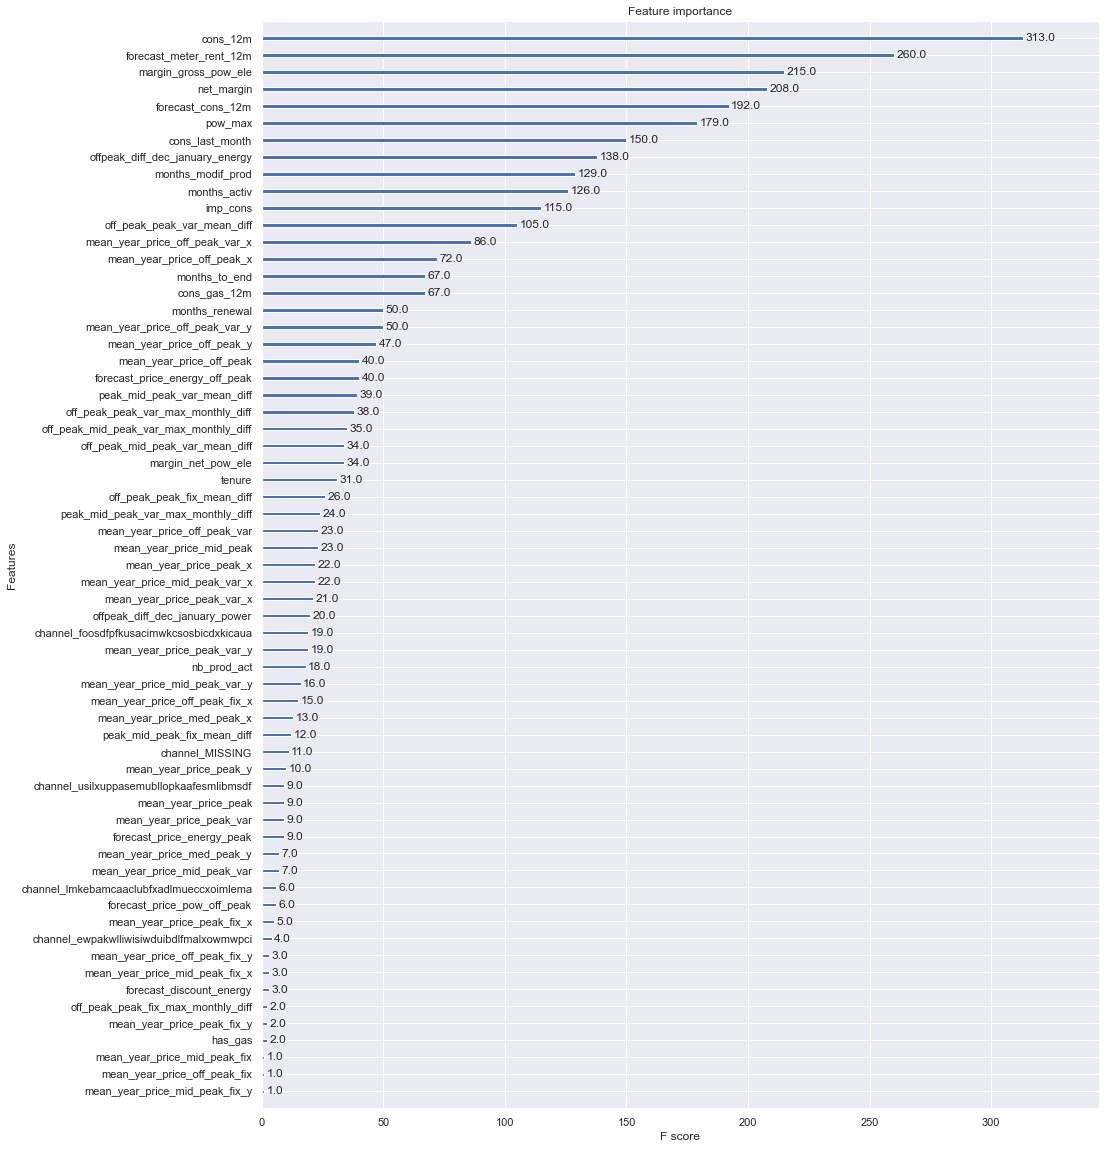

In [58]:
fig, ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(model, ax=ax)

From this chart, we can observe the following points:

- `cons_12m` and `forecast_meter_rent_12m` is a top driver for churn in this model
- Margin on power subscription also is an influential driver
- Time seems to be an influential factor, especially the number of months they have been active, their tenure and the number of months since they updated their contract
- The feature that our colleague recommended is in the top half in terms of how influential it is and some of the features built off the back of this actually outperform it
- Our price sensitivity features are scattered around but are not the main driver for a customer churning

The last observation is important because this relates back to our original hypothesis:

    > Is churn driven by the customers' price sensitivity?

Based on the output of the feature importances, it is not a main driver but it is a weak contributor. However, to arrive at a conclusive result, more experimentation is needed.

#### SHAP - Feature importance

In [60]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


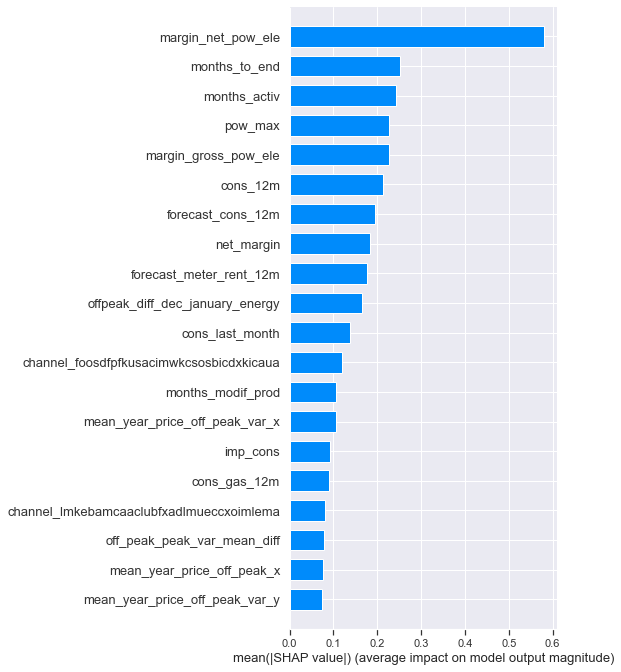

In [61]:
# Feature importance for class 1 - churn
shap.summary_plot(shap_values, X_test, plot_type='bar')

As expected the `margin_net_pow_ele` is the most important feature by far. It is interesting to compare how much important the top feature becomes in contrast with the other models we created Random forest and Logistic Regression.

#### SHAP - Partial dependence plot

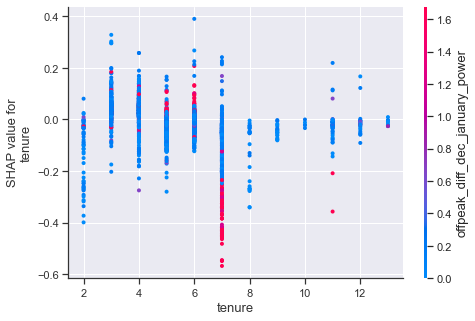

In [62]:
shap.dependence_plot("tenure", shap_values, X_test)#, interaction_index="origin_lxi")

In this case we see a much clearer pattern, in which the longer the tenure the less likely the company is, sort of decreasing linearly until it bottoms around 9y of tenure. From year 10 of tenure, the churn increases again.

#### SHAP - Single prediction

In [71]:
shap.force_plot(explainer.expected_value, shap_values[3651], X_test.iloc[3651,:], link="logit")

We can see in here how the different features interacted to result in the above prediction. In this case, the high values of the `margin_net_pow_ele` and `pow_max` pushed the likely of churning way above the baseline.

In [72]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [73]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [75]:
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')